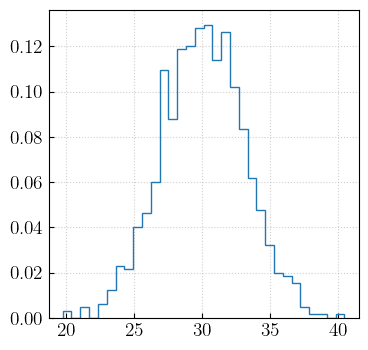

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from tqdm import tqdm
from figaro import plot_settings
%matplotlib inline

mu = 30
sigma = 3
n_samps = 1000
dist = norm(mu, sigma)

samples = dist.rvs(n_samps)

plt.figure(figsize=(4,4))
n, b, p = plt.hist(samples, histtype = 'step', density = True)

In [2]:
from figaro.mixture import DPGMM
from figaro.utils import get_priors

x_min = 10
x_max = 50
bounds = [x_min, x_max]
prior_pars = get_priors(bounds = bounds, samples = samples)

mix = DPGMM(bounds, prior_pars = prior_pars)

In [3]:
for s in tqdm(samples):
    mix.add_new_point(s)

100%|██████████| 1000/1000 [00:06<00:00, 162.93it/s]


In [4]:
rec = mix.build_mixture()

In [5]:
pt = 30
print(rec.pdf(pt), rec.logpdf(pt), rec.cdf(pt), rec.rvs())

[0.1258553] [-2.07262242] [0.50613597] [[29.858246]]


In [6]:
x = np.linspace(x_min, x_max, 1000)
p = rec.pdf(x)

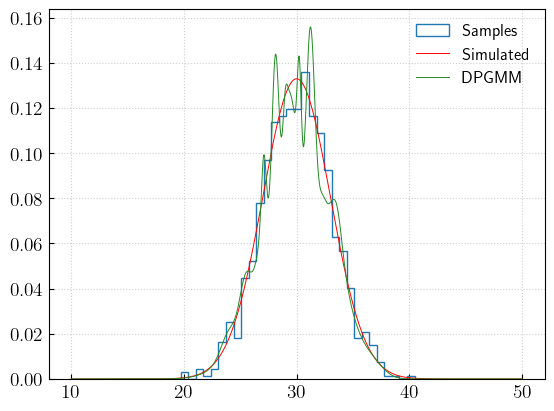

In [7]:
n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p, color = 'forestgreen', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)
plt.show()

In [8]:
n_draws = 100
draws = np.array([mix.density_from_samples(samples) for _ in tqdm(range(n_draws))])

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


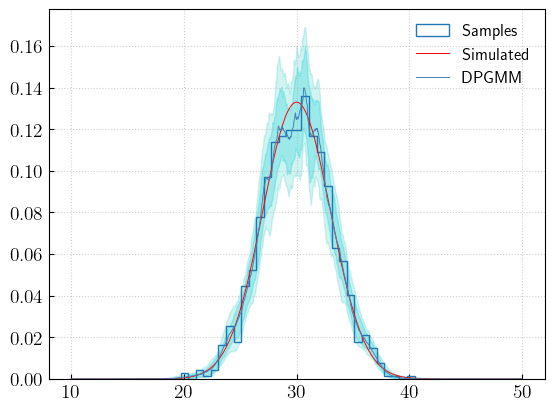

In [9]:
probs = np.array([d.pdf(x) for d in draws])

percentiles = [50, 5, 16, 84, 95]
p = {}
for perc in percentiles:
    p[perc] = np.percentile(probs, perc, axis = 0)
N = p[50].sum()*(x[1]-x[0])
for perc in percentiles:
    p[perc] = p[perc]/N

n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.25)
plt.fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.25)
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p[50], color = 'steelblue', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)

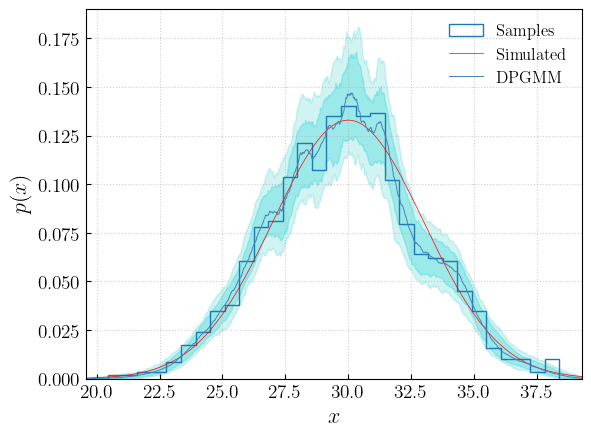

In [14]:
from figaro.plot import plot_median_cr
fig = plot_median_cr(draws,
               injected = dist.pdf,
               samples  = samples,
               save     = False,
               show     = True,
               )

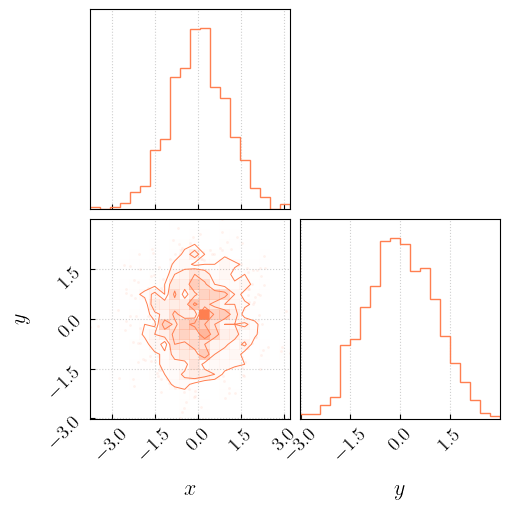

In [10]:
from scipy.stats import multivariate_normal as mn
from corner import corner

n_samps = 1000
samples = mn(np.zeros(2), np.identity(2)).rvs(n_samps)

c = corner(samples, color = 'coral', labels = ['$x$','$y$'], hist_kwargs={'density':True})

In [11]:
x_min = -5
x_max = 5
y_min = -5
y_max = 5

bounds = [[x_min, x_max],[y_min, y_max]]

mix_2d = DPGMM(bounds, prior_pars = get_priors(bounds, samples, scale = 3))

In [12]:
for s in tqdm(samples):
    mix_2d.add_new_point(s)
rec = mix_2d.build_mixture()
mix_2d.initialise()

100%|██████████| 1000/1000 [00:00<00:00, 2236.89it/s]


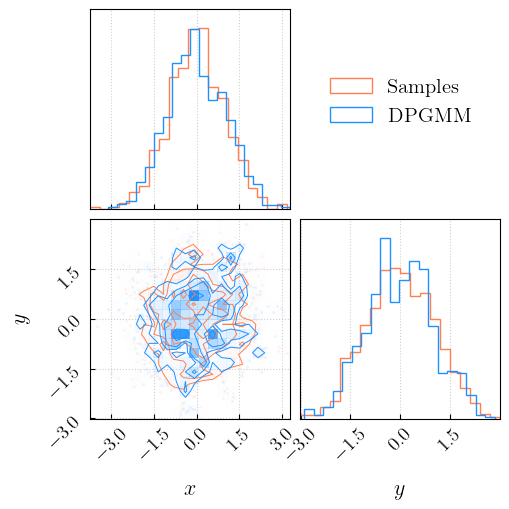

In [13]:
mix_samples = rec.rvs(n_samps)


c = corner(samples, color = 'coral', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{Samples}$'})
c = corner(mix_samples, fig = c, color = 'dodgerblue', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{DPGMM}$'})
l = plt.legend(loc = 0,frameon = False,fontsize = 15, bbox_to_anchor = (1-0.05, 1.8))

In [14]:
n_draws = 100
draws = []

for _ in tqdm(range(n_draws)):
    draws.append(mix_2d.density_from_samples(samples))

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


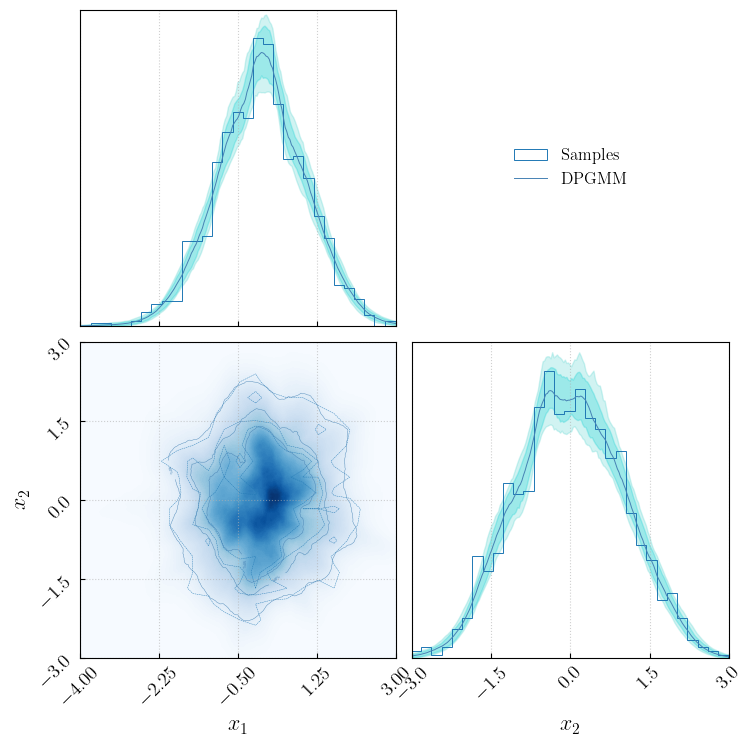

In [15]:
from figaro.plot import plot_multidim

fig = plot_multidim(draws,
                    samples = samples,
                    save = False,
                    )

In [16]:
mu = 30
sigma = 5
n_evs = 100
n_post_samps = 100

mass_function = norm(mu, sigma)
true_masses = mass_function.rvs(n_evs)

single_event_posteriors = [norm(norm(M, s).rvs(), s).rvs(n_post_samps) for M, s in zip(true_masses, np.random.uniform(1,3, size = len(true_masses)))]

In [17]:
n_draws = 10
x_min = 1
x_max = 70
bounds = [[x_min, x_max]]

posteriors = []
for event in tqdm(single_event_posteriors, desc = 'Events'):
    draws = []
    mix = DPGMM(bounds, prior_pars = get_priors(bounds, samples = event))
    for _ in range(n_draws):
        draws.append(mix.density_from_samples(event))
    posteriors.append(draws)

Events: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


In [18]:
from figaro.mixture import HDPGMM
bounds = [[x_min, x_max]]
hier_mix = HDPGMM(bounds, prior_pars = get_priors(bounds, samples = single_event_posteriors, hierarchical = True))

In [19]:
n_draws_hier = 100
hier_draws = []

for _ in tqdm(range(n_draws_hier)):
    hier_draws.append(hier_mix.density_from_samples(posteriors))

100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


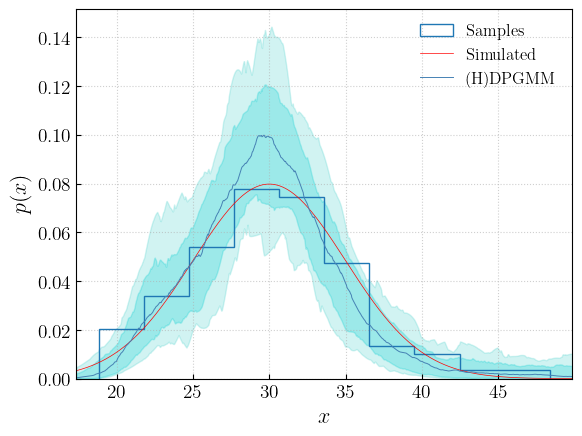

In [21]:
from figaro.plot import plot_median_cr
fig = plot_median_cr(hier_draws,
                     samples      = true_masses,
                     injected     = mass_function.pdf,
                     show         = True,
                     hierarchical = True
                     )